## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5geore' #dataset-compression
TRANSFORM = 'stft-strong_intensity' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
strong_intensity_stft_1e5geore_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5geore\\stft\\strong_intensity'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


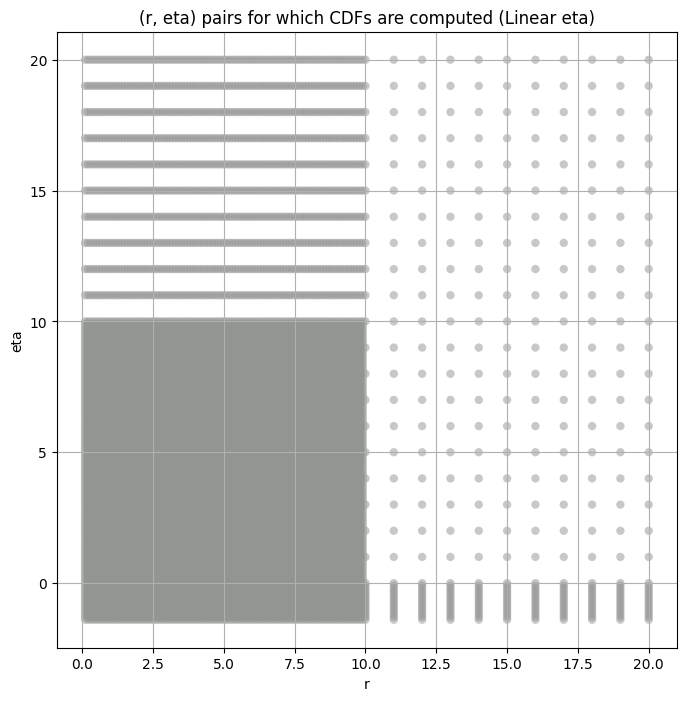

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                        
2     57.350895  47.316536  75.235180    81.11204   20.601892   304.70905   
3     28.362835  23.131216  39.158527   108.53434   22.784437   426.03480   
4     19.804796  15.818209  27.395380   116.36713   31.201988   433.28998   
5     11.807234   9.242341  16.384570   127.57010   39.797090   437.54810   
6      9.799885   7.317126  17.313768   366.21494   40.987793  1174.94620   
7      3.985288   3.034718   5.718637   155.70680   44.850530   512.40840   
8      1.070987   0.702098   2.883485  1710.57890   40.346313  3236.24270   
9      0.259080   0.183806   0.485760   479.14316   54.962437  1437.06140   

      total_samples  
band                 
2          100000.0  
3          100000.0  
4          100000.0  
5          100000.0  
6          100000.0  
7          100000.0  
8          100000.0  
9          100000.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                             
2     57.350895      57.350895       50.087795       47.334736   
3     28.362835      28.362835       24.512136       23.081779   
4     19.804796      19.804796       17.017685       15.874792   
5     11.807234      11.807234        9.988566        9.215591   
6      9.799885       9.799885        7.923755        7.310689   
7      3.985288       3.985288        3.283072        3.003135   
8      1.070987       1.070987        0.758925        0.698575   
9      0.259080       0.259080        0.200313        0.180873   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2          45.328465        43.714230        41.146122        39.111954   
3          22.035343        21.188860        19.847900        18.789042   
4          15.016210        14.313603        13.197138        12.316734   
5           8.638279         8.170228         7.430079         6.851031   
6           6.849649         6.472932         5.871171         5.398418   
7           2.799336         2.635801         2.380717         2.183738   
8           0.654396         0.618750         0.562547         0.518740   
9           0.166658         0.155304         0.137781         0.124504   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2           37.412426        35.940735        34.640717        31.458702  
3           17.908117        17.153769        16.493839        14.892060  
4           11.586329        10.963005        10.418921         9.118260  
5            6.374247         5.969893         5.620292         4.795573  
6            5.007702         4.675628         4.388020         3.707481  
7            2.023175         1.888023         1.771838         1.500290  
8            0.482757         0.452326         0.426024         0.364059  
9            0.113903         0.105154         0.097782         0.081145

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.007309347578934311 57.350895


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.006348920822603521 50.087795


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.005412980670149503 47.334736


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.0047923363536735986 45.328465


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.0059364177891436665 43.71423


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.00388993146211436 41.146122


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.005303017402915826 39.111954


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.006784391756910098 37.412426


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.00738200283711965 35.940735


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.0063361911046495335 34.640717


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.008918990618950472 31.458702
Number of samples: 100000, Without approximation : 100000.0


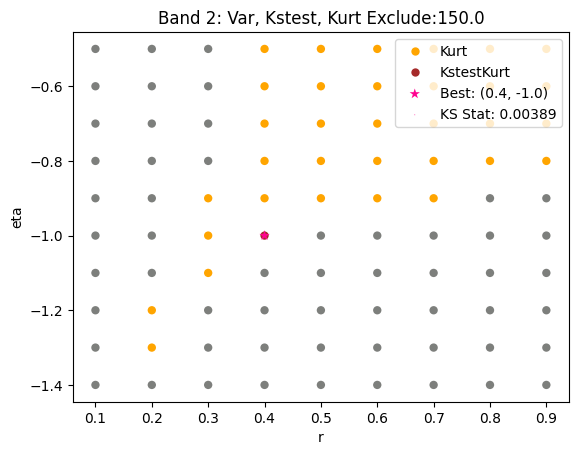

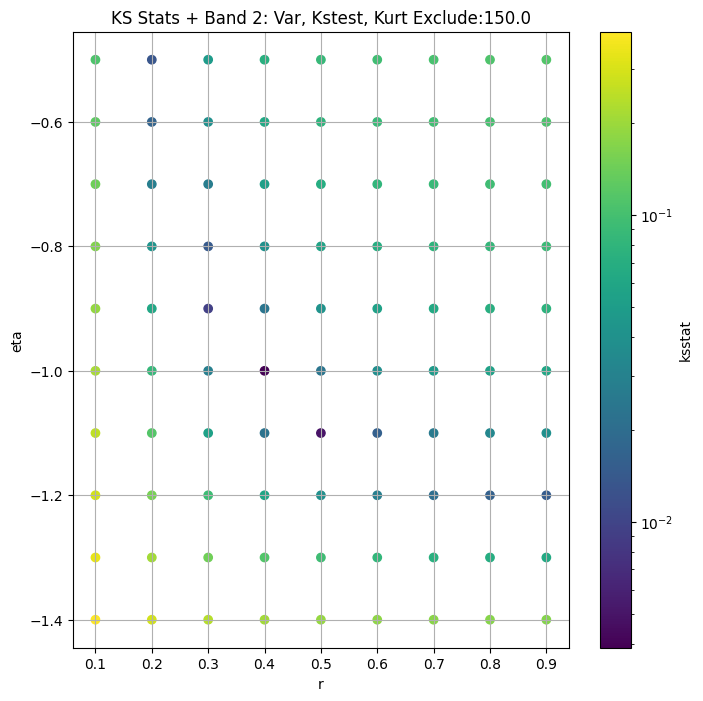

####
Band  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.002682919988942989 28.362835


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.0038965799974124415 24.512136


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.005674897927276712 23.08178


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.007721307020160717 22.035343


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.009597624726341791 21.18886


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.0076930897478399984 19.8479


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.004822477396969949 18.789042


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.0048714202253517455 17.908117


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.006087515065606827 17.153769


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.007403595364363337 16.49384


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.008627656013404119 14.89206
Number of samples: 100000, Without approximation : 100000.0


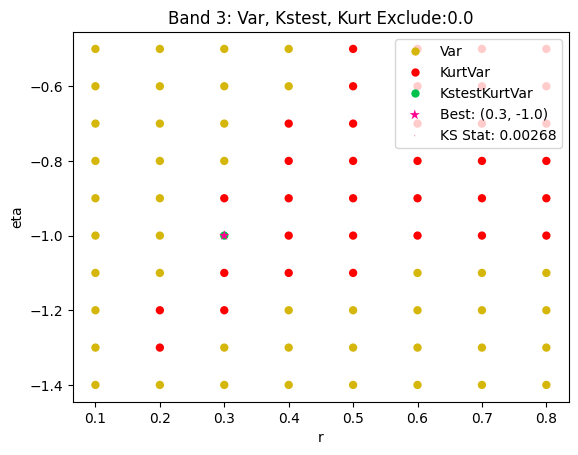

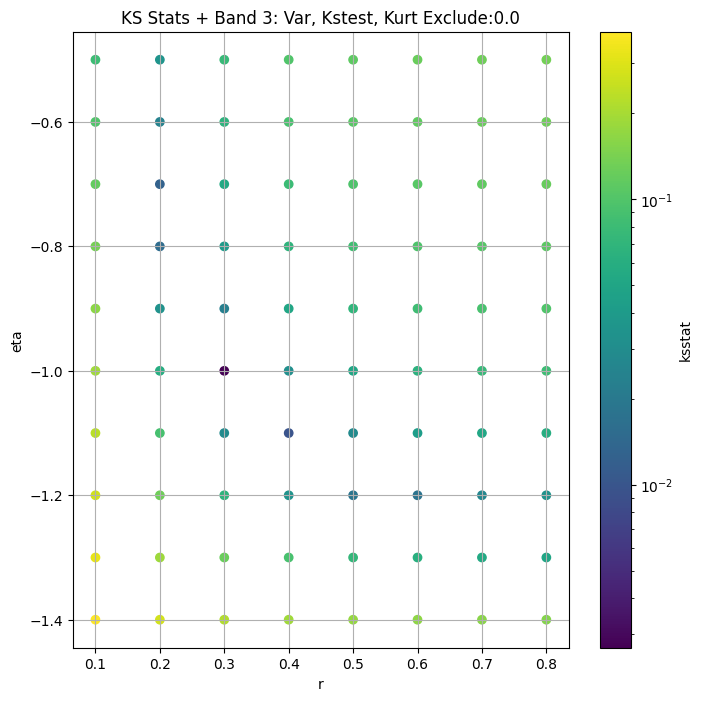

####
Band  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.005029331593063402 19.804796


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.007340009546205228 17.017685


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.008148152976978573 15.874792


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.00888180002066652 15.01621


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.009816926769308953 14.313603


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.0102449447508276 13.197138


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.010747399632629412 12.316734


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.010182123040592628 11.586329


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.008154501376219314 10.963005


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.007827774109738117 10.418921


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.009006286902990143 9.11826
Number of samples: 100000, Without approximation : 100000.0


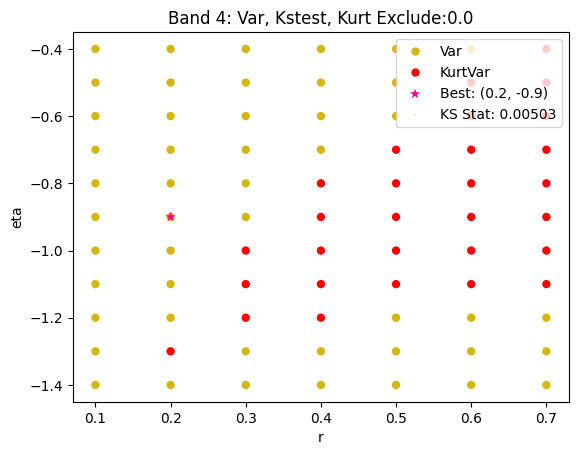

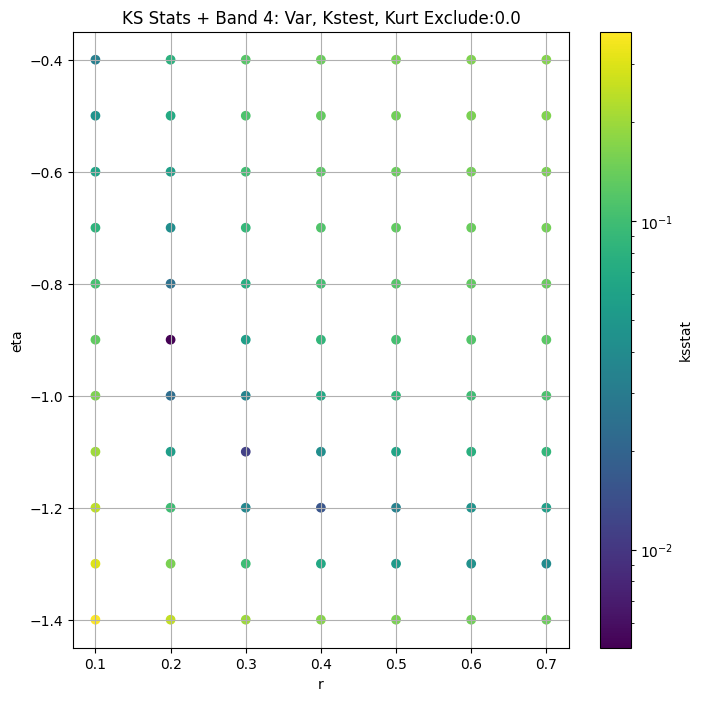

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.0052884885396328185 11.807234


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.009828499325295614 9.988566


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.007630834890106852 9.215591


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.004806650105107613 8.638279


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.0034899061814046874 8.170228


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.007703256087471411 7.430079


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.010416410827275957 6.851031


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.007676104181917998 6.374247


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.0069236655199598 5.969893


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.007931476403979176 5.620292


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.008635402658160016 4.7955728
Number of samples: 100000, Without approximation : 100000.0


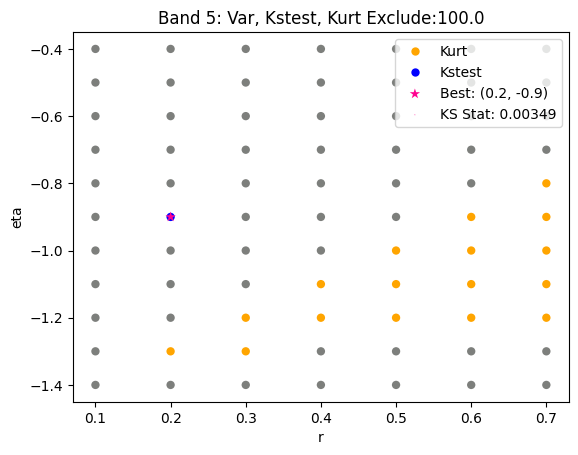

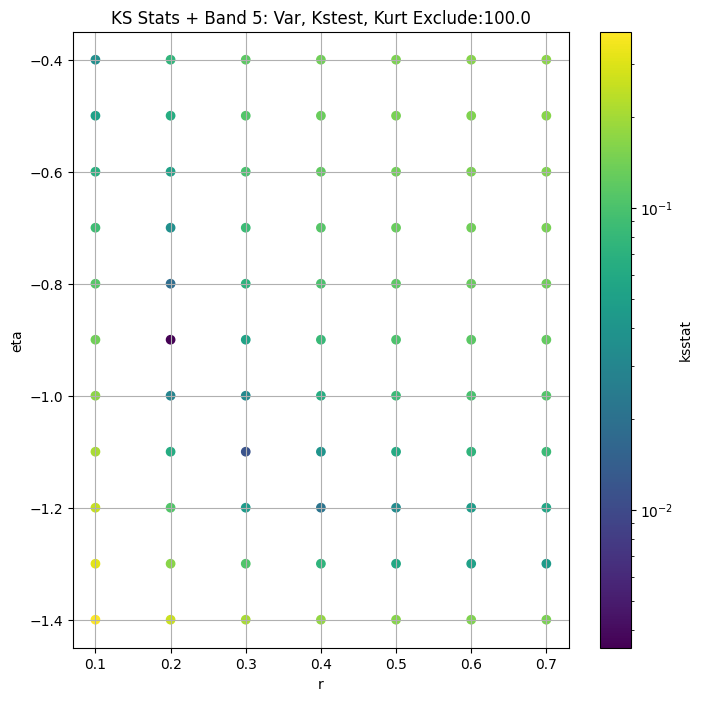

####
Band  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.00962727273008035 9.799885


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.009515211242130506 7.923755


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.007700789762839277 7.3106894


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.0061439133928465894 6.849649


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.00793021751934353 6.4729323


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.00832213428662898 5.8711715


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.008274340983325607 5.398418


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.00700013704644209 5.0077024


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.006541057470660692 4.675628


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.007295918763412023 4.3880196


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.00834258397716514 3.7074811
Number of samples: 100000, Without approximation : 100000.0


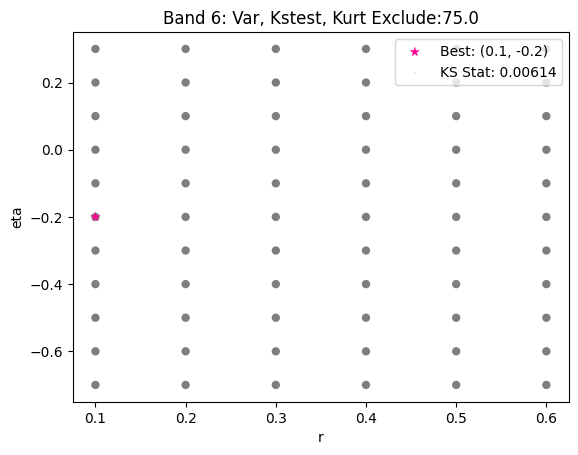

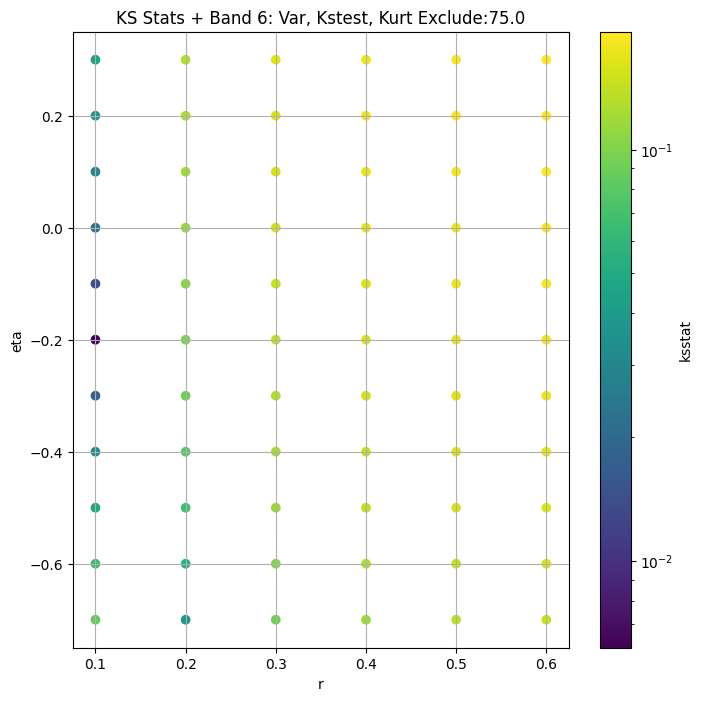

####
Band  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.007524822843248846 3.985288


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.005924196507249624 3.2830718


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.005931825924768763 3.003135


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.008488039317455787 2.7993362


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.00794841428933779 2.6358006


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.008146882224194962 2.380717


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.0070620550790209125 2.1837382


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.00573235997605622 2.0231752


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.006580250030856613 1.8880227


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.008581048564659244 1.7718376


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.00840488032658349 1.5002898
Number of samples: 100000, Without approximation : 100000.0


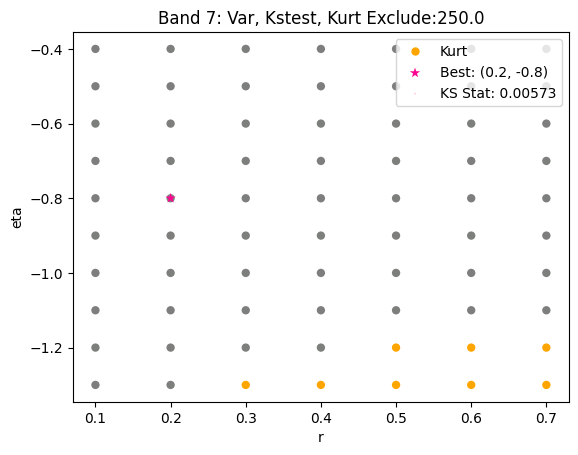

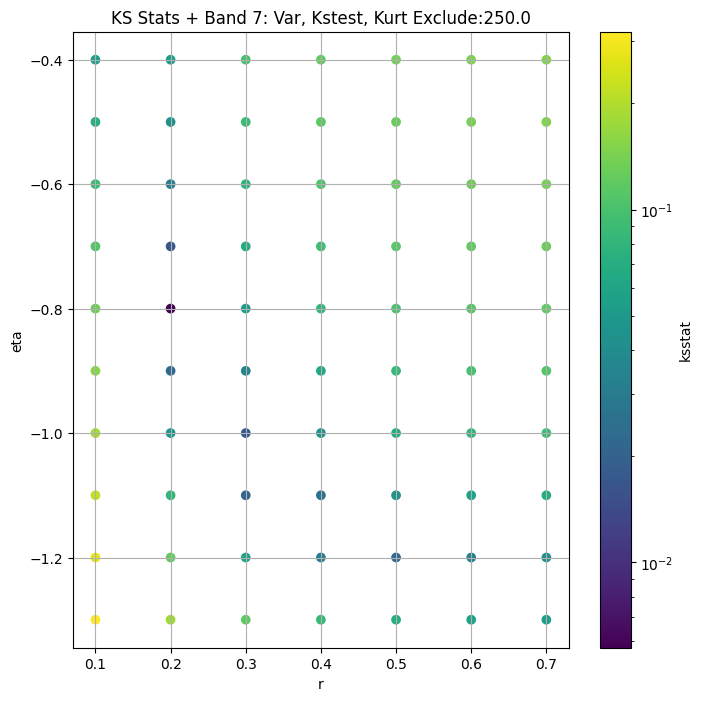

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.009766809762724149 1.0709867


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.0030488107583106494 0.7589254


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.0065529408638120845 0.69857496


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.004505689959843018 0.6543958


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.004699541749972086 0.61874956


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.005796266349104573 0.5625466


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.00676863644137074 0.51873994


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.005455200255555986 0.48275706


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.006243276449319664 0.4523263


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.007076963428200255 0.42602435


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.008184473073279599 0.36405864
Number of samples: 100000, Without approximation : 100000.0


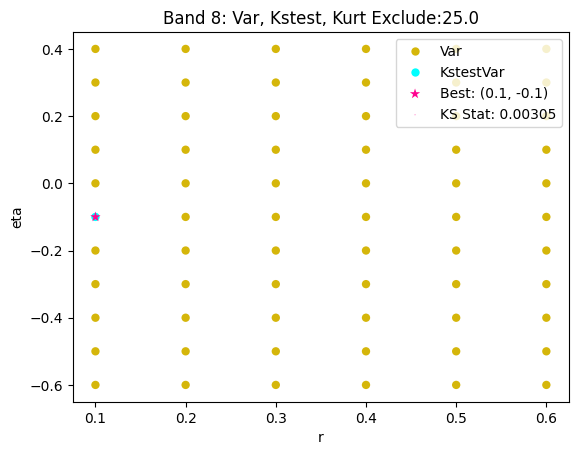

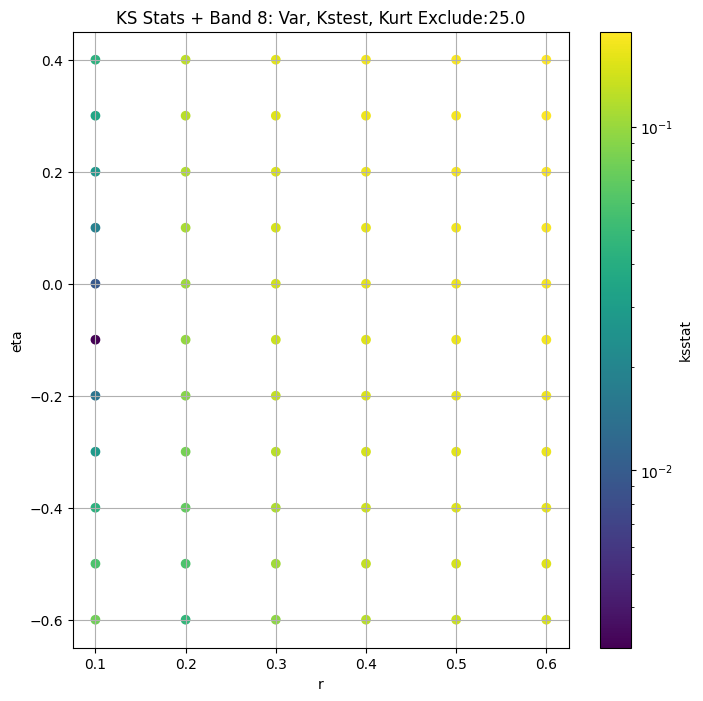

####
Band  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.011809310437866816 0.25908038


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.006721360534549414 0.20031253


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.007062762621817209 0.1808729


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.004577501534070549 0.1666582


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.004401537985307347 0.15530415


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.006537722286419578 0.13778134


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.004411857780690309 0.12450427


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.006198975451544464 0.11390321


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.008191816279256803 0.105153866


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.0059350702115304535 0.09778222


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.010186942264963222 0.08114461
Number of samples: 100000, Without approximation : 100000.0


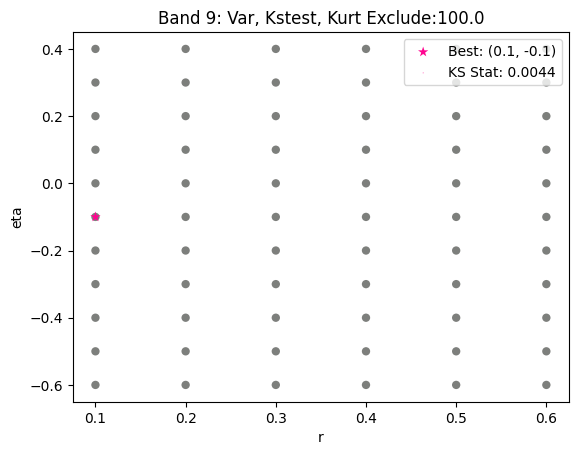

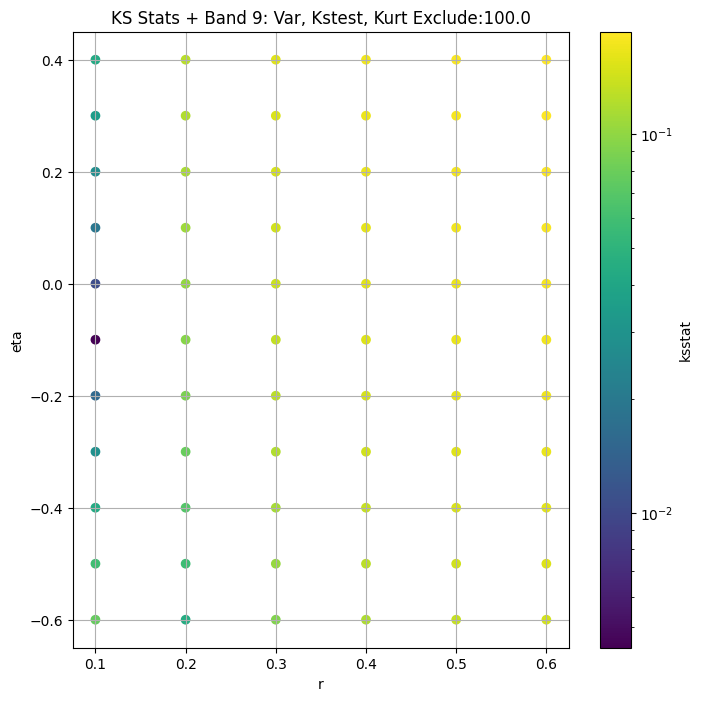

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                        
2     57.350895  47.316536  75.235180    81.11204   20.601892   304.70905   
3     28.362835  23.131216  39.158527   108.53434   22.784437   426.03480   
4     19.804796  15.818209  27.395380   116.36713   31.201988   433.28998   
5     11.807234   9.242341  16.384570   127.57010   39.797090   437.54810   
6      9.799885   7.317126  17.313768   366.21494   40.987793  1174.94620   
7      3.985288   3.034718   5.718637   155.70680   44.850530   512.40840   
8      1.070987   0.702098   2.883485  1710.57890   40.346313  3236.24270   
9      0.259080   0.183806   0.485760   479.14316   54.962437  1437.06140   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2          100000.0             0.003890        0.4         -1.0   
3          100000.0             0.002683        0.3         -1.0   
4          100000.0             0.005029        0.2         -0.9   
5          100000.0             0.003490        0.2         -0.9   
6          100000.0             0.006144        0.1         -0.2   
7          100000.0             0.005732        0.2         -0.8   
8          100000.0             0.003049        0.1         -0.1   
9          100000.0             0.004402        0.1         -0.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      8.432070e+00                   150.0           41.146122   
3      1.066851e+00                     0.0           28.362835   
4      7.859046e-03                     0.0           19.804796   
5      3.242154e-03                   100.0            8.170228   
6      2.919031e-12                    75.0            6.849649   
7      4.790884e-04                   250.0            2.023175   
8      1.828037e-13                    25.0            0.758925   
9      3.740838e-14                   100.0            0.155304   

      kstest_stat_cutoff_0.05  
band                           
2                    0.004293  
3                    0.004293  
4                    0.004293  
5                    0.004293  
6                    0.004293  
7                    0.004293  
8                    0.004293  
9                    0.004293

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 150.0 + 100 = 250, ksstat: 0.00484288071370529, var: 37.41242599487305


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 150.0 + 75 = 225, ksstat: 0.004434748141595647, var: 38.229026794433594


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 150.0 + 50 = 200, ksstat: 0.004019594169659333, var: 39.11195373535156


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 150.0 + 25 = 175, ksstat: 0.0036820709349691637, var: 40.07744216918945


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 150.0 + 0 = 150, ksstat: 0.00388993146211436, var: 41.146121978759766


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 150.0 + -25 = 125, ksstat: 0.003273013691890543, var: 42.34511947631836


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 150.0 + -50 = 100, ksstat: 0.002673083816171106, var: 43.714229583740234


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 150.0 + -75 = 75, ksstat: 0.001987058831749284, var: 45.32846450805664


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
band 2, 150.0 + -100 = 50, ksstat: 0.0018979419037257195, var: 47.33473587036133
Number of samples: 100000, Without approximation : 100000.0


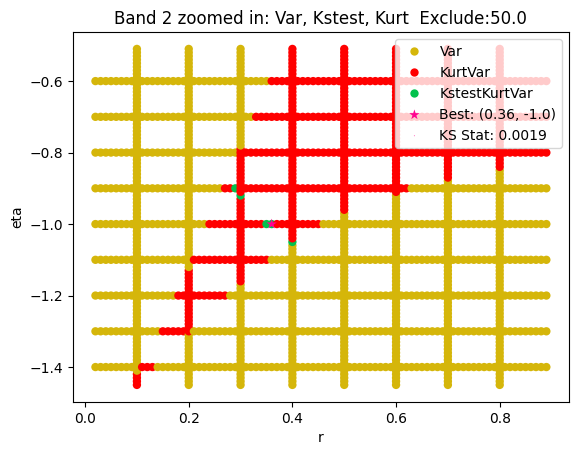

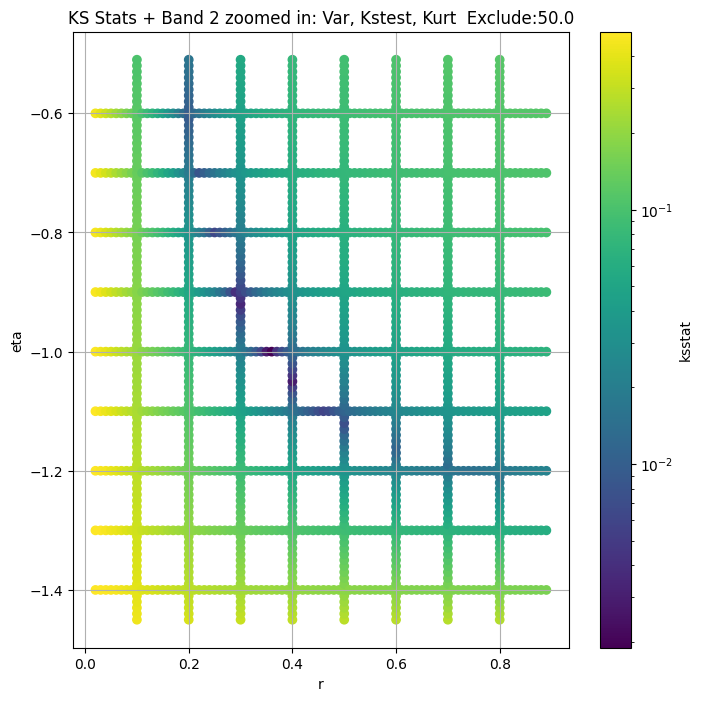

Band 3


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 3, 0.0 + 100 = 100, ksstat: 0.0023112866344436322, var: 21.188859939575195


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 3, 0.0 + 75 = 75, ksstat: 0.0016983283754086753, var: 22.035343170166016


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 3, 0.0 + 50 = 50, ksstat: 0.0022267724303409175, var: 23.08177947998047


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 3, 0.0 + 25 = 25, ksstat: 0.003125212820430545, var: 24.512136459350586


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 3, 0.0 + 0 = 0, ksstat: 0.002682919988942989, var: 28.362834930419922
Number of samples: 100000, Without approximation : 100000.0


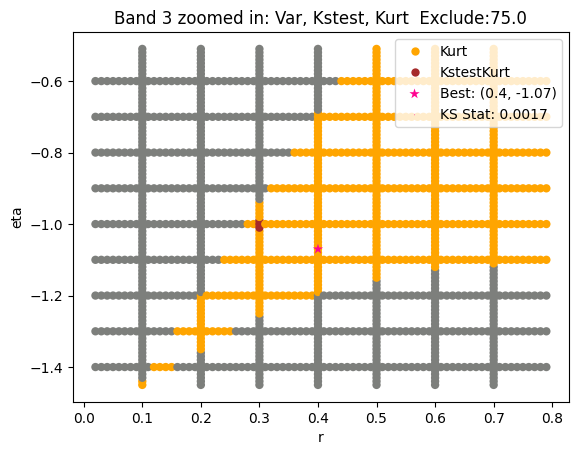

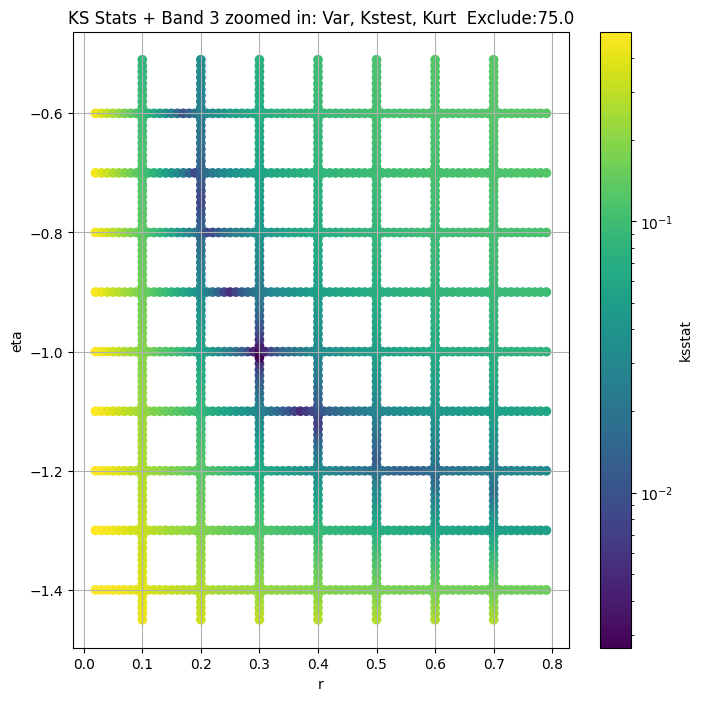

Band 4


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 0.0 + 100 = 100, ksstat: 0.0031768603270386497, var: 14.313603401184082


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 0.0 + 75 = 75, ksstat: 0.004116817064024669, var: 15.016209602355957


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 0.0 + 50 = 50, ksstat: 0.0023941984323728738, var: 15.874792098999023


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 0.0 + 25 = 25, ksstat: 0.0031184386894350102, var: 17.017684936523438


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 4, 0.0 + 0 = 0, ksstat: 0.003025119799706766, var: 19.80479621887207
Number of samples: 100000, Without approximation : 100000.0


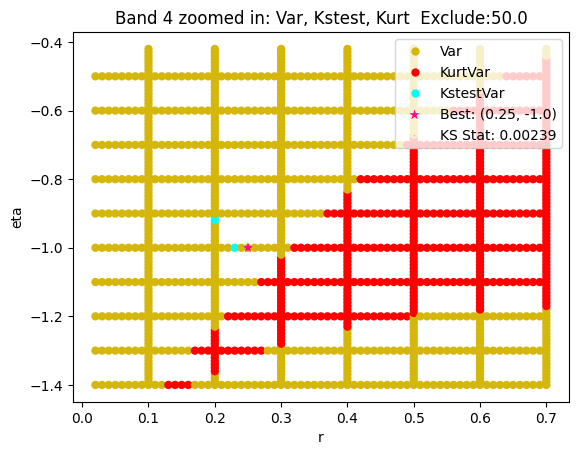

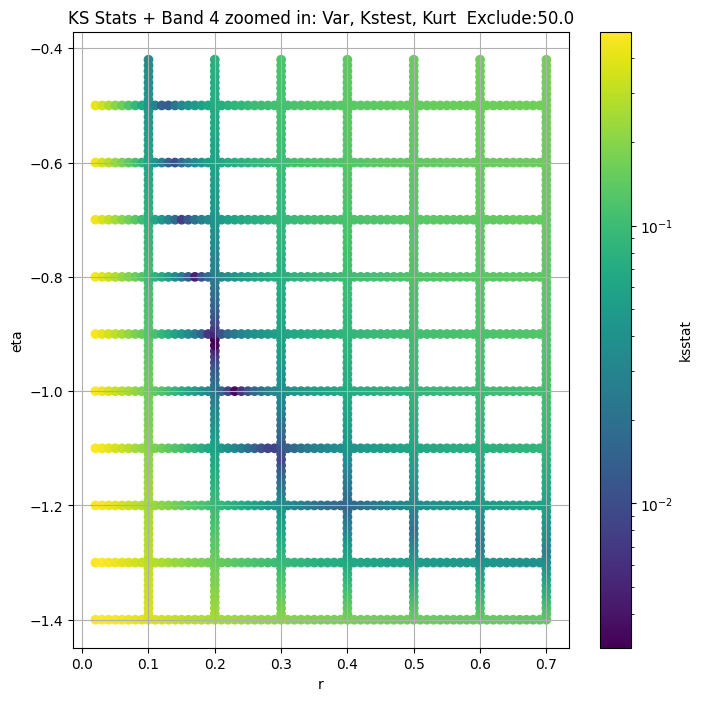

Band 5


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + 100 = 200, ksstat: 0.004962043096046958, var: 6.8510308265686035


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + 75 = 175, ksstat: 0.004756489379487373, var: 7.1251983642578125


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + 50 = 150, ksstat: 0.004269124398309912, var: 7.430078983306885


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + 25 = 125, ksstat: 0.003898843303495903, var: 7.774130344390869


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + 0 = 100, ksstat: 0.0034496499738803175, var: 8.170228004455566


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + -25 = 75, ksstat: 0.0036760510283043724, var: 8.63827896118164


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + -50 = 50, ksstat: 0.0030983452362061126, var: 9.215591430664062


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + -75 = 25, ksstat: 0.004183430435761526, var: 9.988566398620605


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 5, 100.0 + -100 = 0, ksstat: 0.004974952107160813, var: 11.807233810424805
Number of samples: 100000, Without approximation : 100000.0


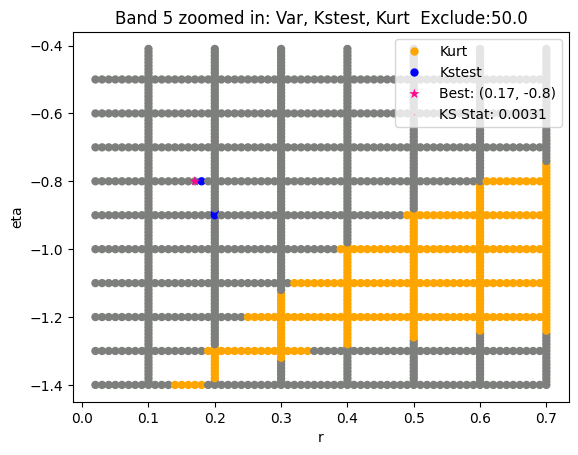

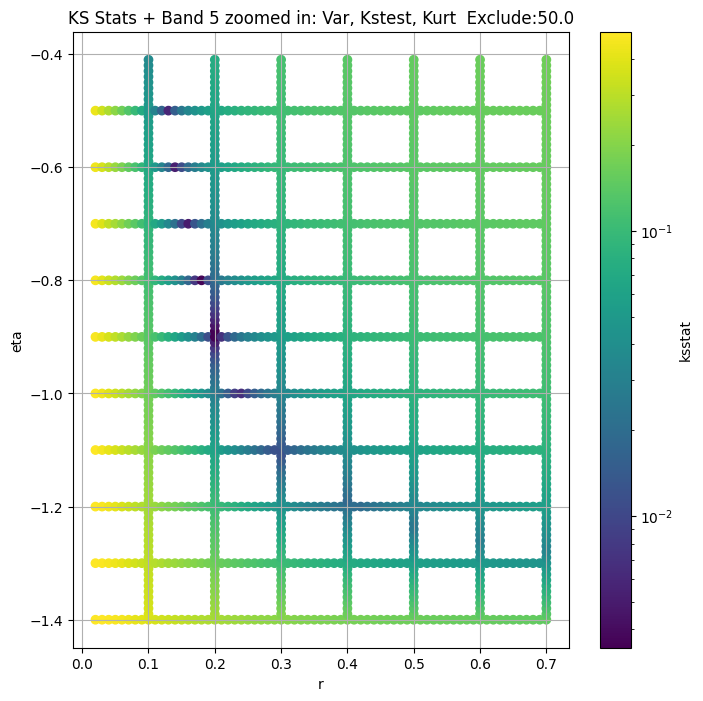

Band 6


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 75.0 + 100 = 175, ksstat: 0.006029393911241521, var: 5.6223649978637695


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 75.0 + 75 = 150, ksstat: 0.004826151619753647, var: 5.871171474456787


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 75.0 + 50 = 125, ksstat: 0.00447642554646166, var: 6.151692867279053


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 75.0 + 25 = 100, ksstat: 0.004220479506211792, var: 6.4729323387146


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 75.0 + 0 = 75, ksstat: 0.005143575040225112, var: 6.849648952484131


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 75.0 + -25 = 50, ksstat: 0.005360780295004752, var: 7.310689449310303


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 75.0 + -50 = 25, ksstat: 0.004538091408516909, var: 7.923755168914795


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 75.0 + -75 = 0, ksstat: 0.00501997356977435, var: 9.799884796142578
Number of samples: 100000, Without approximation : 100000.0


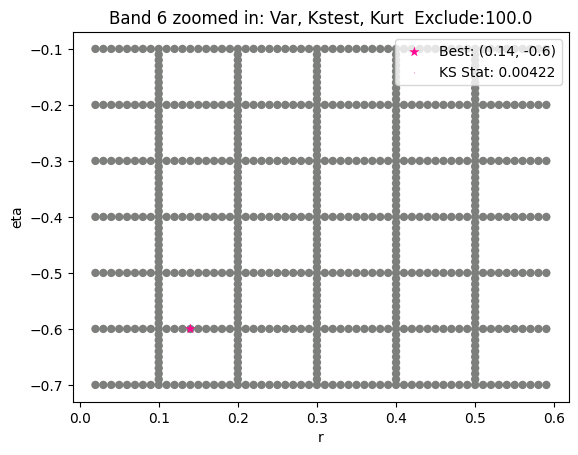

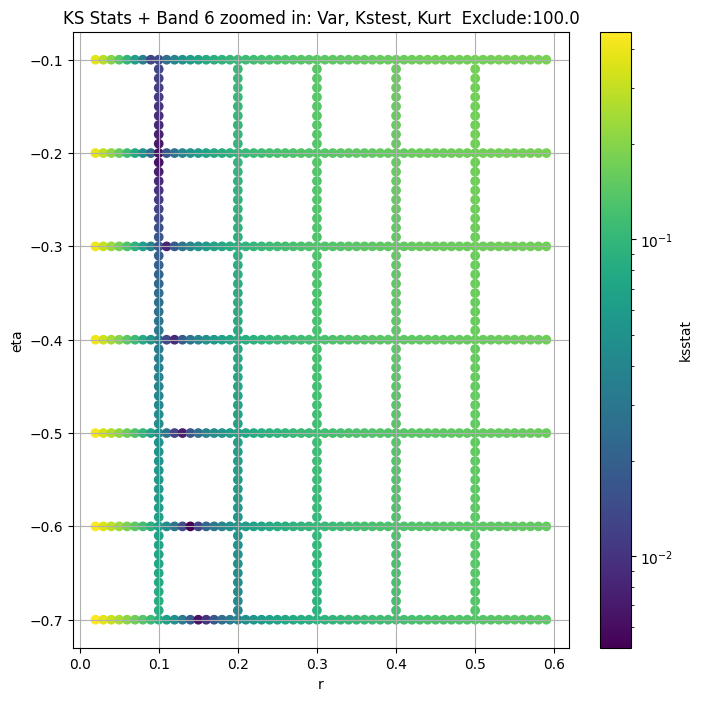

Band 7


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 7, 250.0 + 100 = 350, ksstat: 0.006421418557709835, var: 1.771837592124939


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 7, 250.0 + 75 = 325, ksstat: 0.006183383878958311, var: 1.8278547525405884


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 7, 250.0 + 50 = 300, ksstat: 0.006078342854202197, var: 1.8880226612091064


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 7, 250.0 + 25 = 275, ksstat: 0.005845391489330049, var: 1.9528793096542358


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 7, 250.0 + 0 = 250, ksstat: 0.0054460935260330495, var: 2.0231752395629883


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 7, 250.0 + -25 = 225, ksstat: 0.005308408360306436, var: 2.0997281074523926


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 7, 250.0 + -50 = 200, ksstat: 0.004932228354659136, var: 2.1837382316589355


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 7, 250.0 + -75 = 175, ksstat: 0.004645691438202974, var: 2.276740789413452


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 7, 250.0 + -100 = 150, ksstat: 0.004714898959480077, var: 2.3807170391082764
Number of samples: 100000, Without approximation : 100000.0


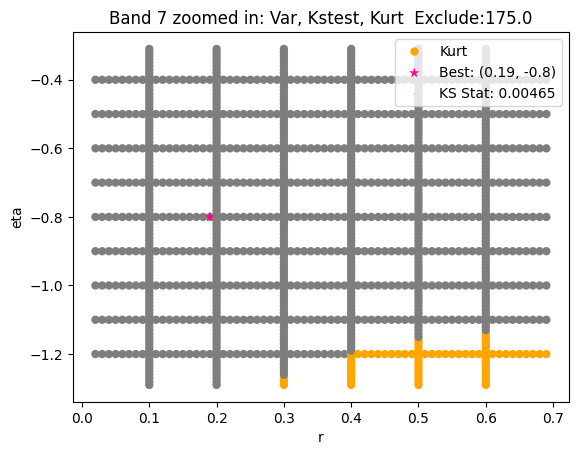

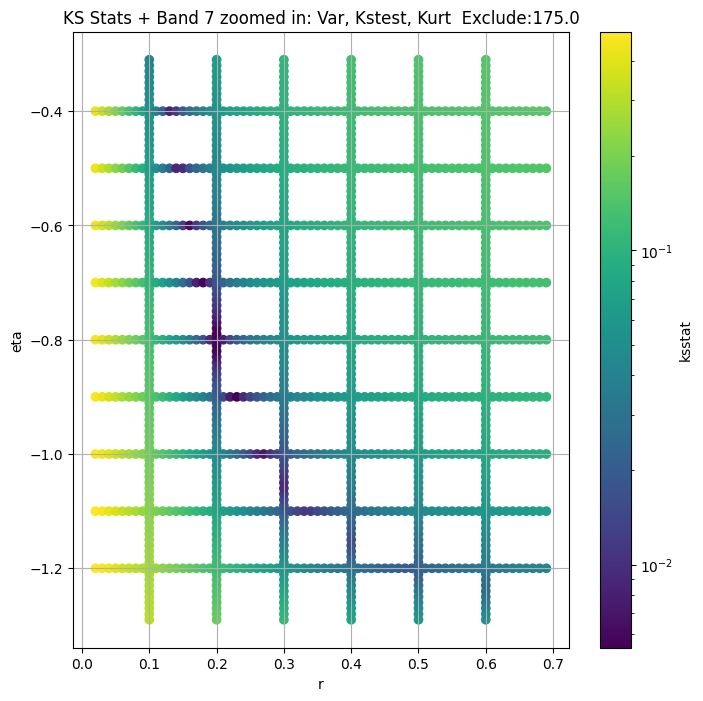

Band 8


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 25.0 + 100 = 125, ksstat: 0.003987819365392387, var: 0.5886467695236206


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 25.0 + 75 = 100, ksstat: 0.004419811604157491, var: 0.6187495589256287


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 25.0 + 50 = 75, ksstat: 0.0032567828988589176, var: 0.6543958187103271


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 25.0 + 25 = 50, ksstat: 0.002940794147473119, var: 0.698574960231781


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 25.0 + 0 = 25, ksstat: 0.0030488107583106494, var: 0.7589253783226013


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 8, 25.0 + -25 = 0, ksstat: 0.0073868641135562685, var: 1.0709867477416992
Number of samples: 100000, Without approximation : 100000.0


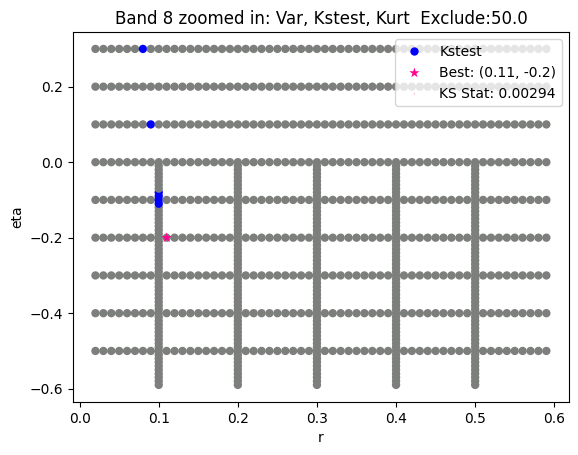

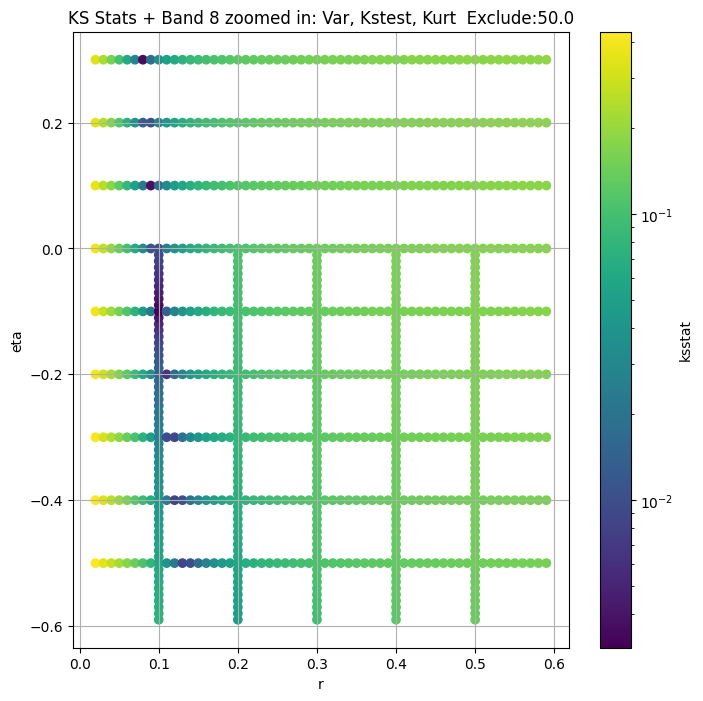

Band 9


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 9, 100.0 + 100 = 200, ksstat: 0.00571210979899317, var: 0.12450426816940308


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 9, 100.0 + 75 = 175, ksstat: 0.005044616749582703, var: 0.1307344287633896


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 9, 100.0 + 50 = 150, ksstat: 0.0035650182303775674, var: 0.13778133690357208


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 9, 100.0 + 25 = 125, ksstat: 0.003605507866569879, var: 0.14586012065410614


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 9, 100.0 + 0 = 100, ksstat: 0.0033474579262833815, var: 0.15530414879322052


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 9, 100.0 + -25 = 75, ksstat: 0.0029595338417698347, var: 0.1666581928730011


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 9, 100.0 + -50 = 50, ksstat: 0.0036514473902683475, var: 0.18087290227413177


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 9, 100.0 + -75 = 25, ksstat: 0.005297280214597522, var: 0.2003125250339508


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
band 9, 100.0 + -100 = 0, ksstat: 0.007627285626314206, var: 0.2590803802013397
Number of samples: 100000, Without approximation : 100000.0


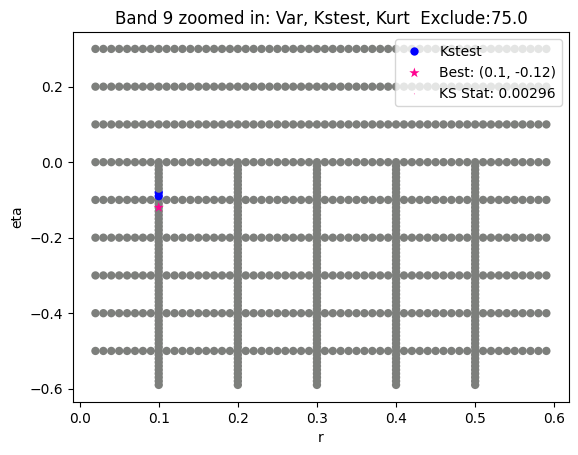

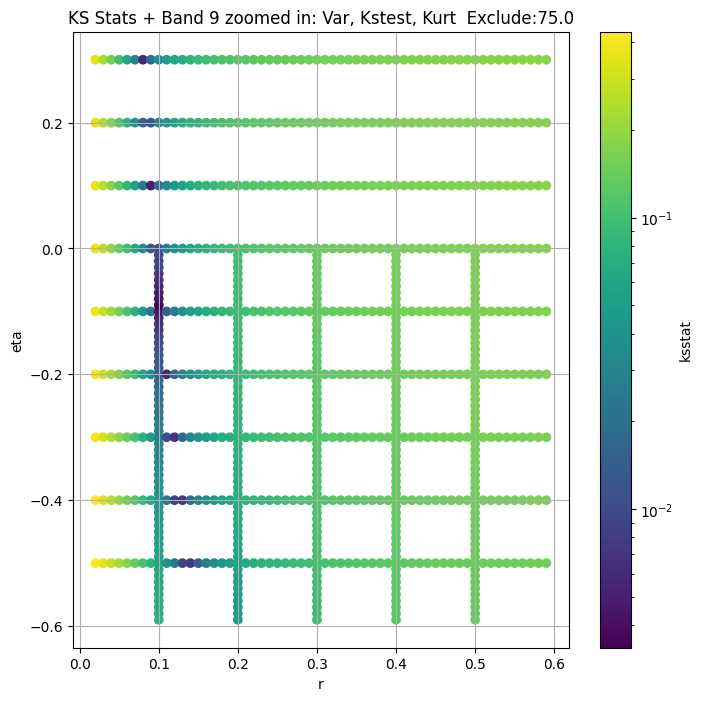

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                        
2     57.350895  47.316536  75.235180    81.11204   20.601892   304.70905   
3     28.362835  23.131216  39.158527   108.53434   22.784437   426.03480   
4     19.804796  15.818209  27.395380   116.36713   31.201988   433.28998   
5     11.807234   9.242341  16.384570   127.57010   39.797090   437.54810   
6      9.799885   7.317126  17.313768   366.21494   40.987793  1174.94620   
7      3.985288   3.034718   5.718637   155.70680   44.850530   512.40840   
8      1.070987   0.702098   2.883485  1710.57890   40.346313  3236.24270   
9      0.259080   0.183806   0.485760   479.14316   54.962437  1437.06140   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2          100000.0             0.003890        0.4         -1.0   
3          100000.0             0.002683        0.3         -1.0   
4          100000.0             0.005029        0.2         -0.9   
5          100000.0             0.003490        0.2         -0.9   
6          100000.0             0.006144        0.1         -0.2   
7          100000.0             0.005732        0.2         -0.8   
8          100000.0             0.003049        0.1         -0.1   
9          100000.0             0.004402        0.1         -0.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      8.432070e+00                   150.0           47.334736   
3      1.066851e+00                     0.0           22.035343   
4      7.859046e-03                     0.0           15.874792   
5      3.242154e-03                   100.0            9.215591   
6      2.919031e-12                    75.0            6.472932   
7      4.790884e-04                   250.0            2.276741   
8      1.828037e-13                    25.0            0.698575   
9      3.740838e-14                   100.0            0.166658   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.004293          0.001898    0.36     -1.00   
3                    0.004293          0.001698    0.40     -1.07   
4                    0.004293          0.002394    0.25     -1.00   
5                    0.004293          0.003098    0.17     -0.80   
6                    0.004293          0.004220    0.14     -0.60   
7                    0.004293          0.004646    0.19     -0.80   
8                    0.004293          0.002941    0.11     -0.20   
9                    0.004293          0.002960    0.10     -0.12   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     5.659769e+00                 50.0     506250.0  
3     5.866100e+00                 75.0     640720.0  
4     1.322899e-01                 50.0     337500.0  
5     1.769842e-04                 50.0     189843.0  
6     7.981669e-07                100.0     100000.0  
7     2.587435e-04                175.0      84375.0  
8     9.686321e-12                 50.0     225000.0  
9     4.487679e-14                 75.0     213573.0

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

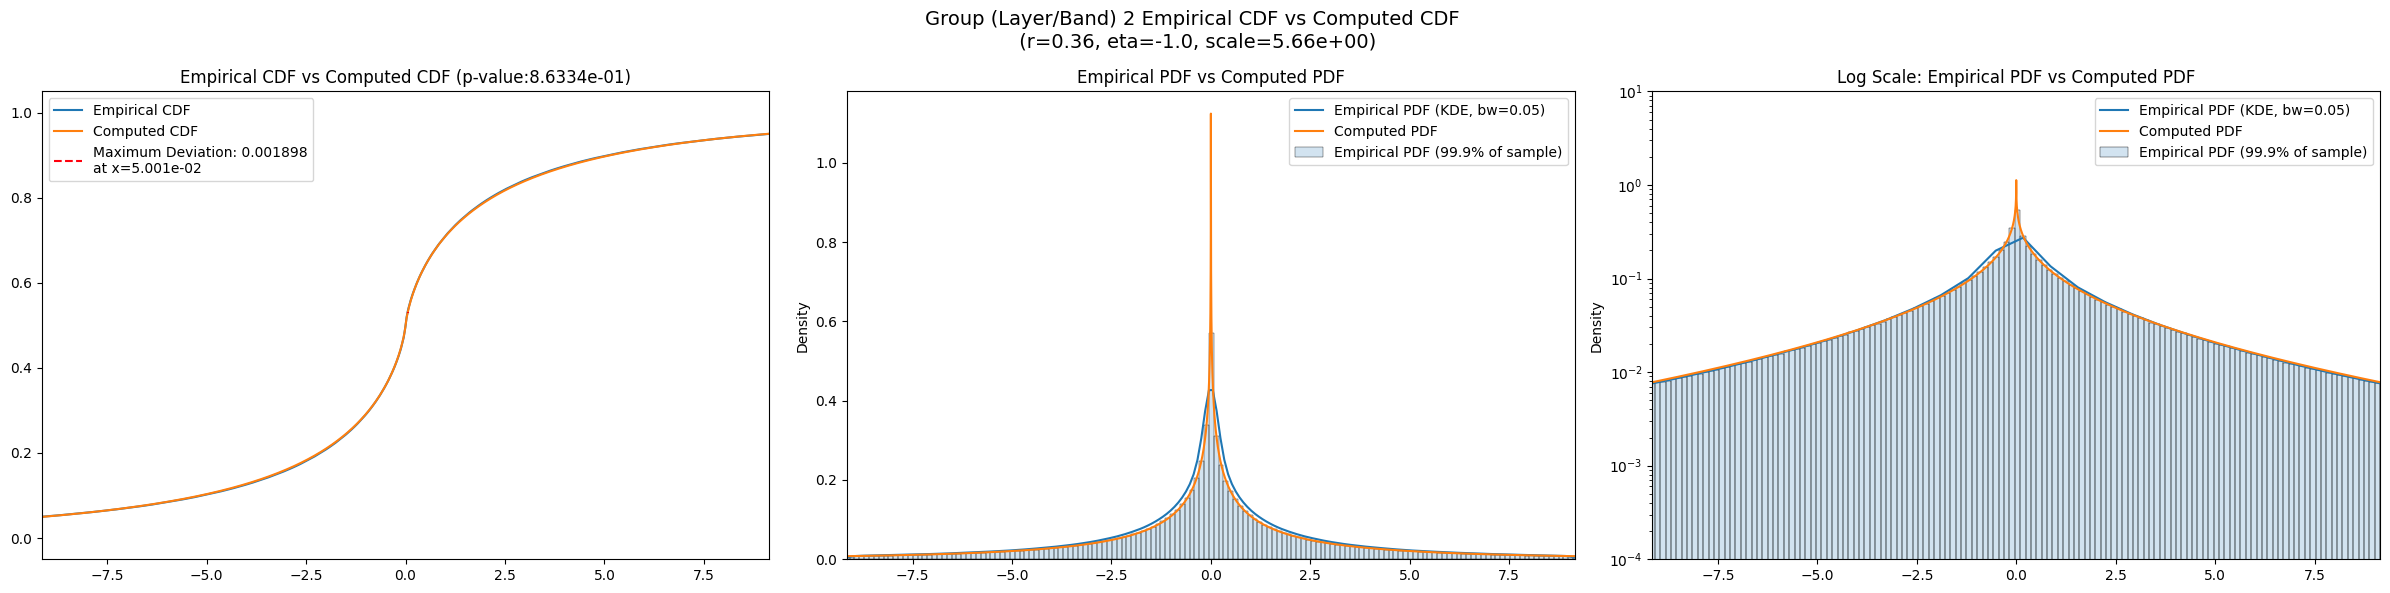

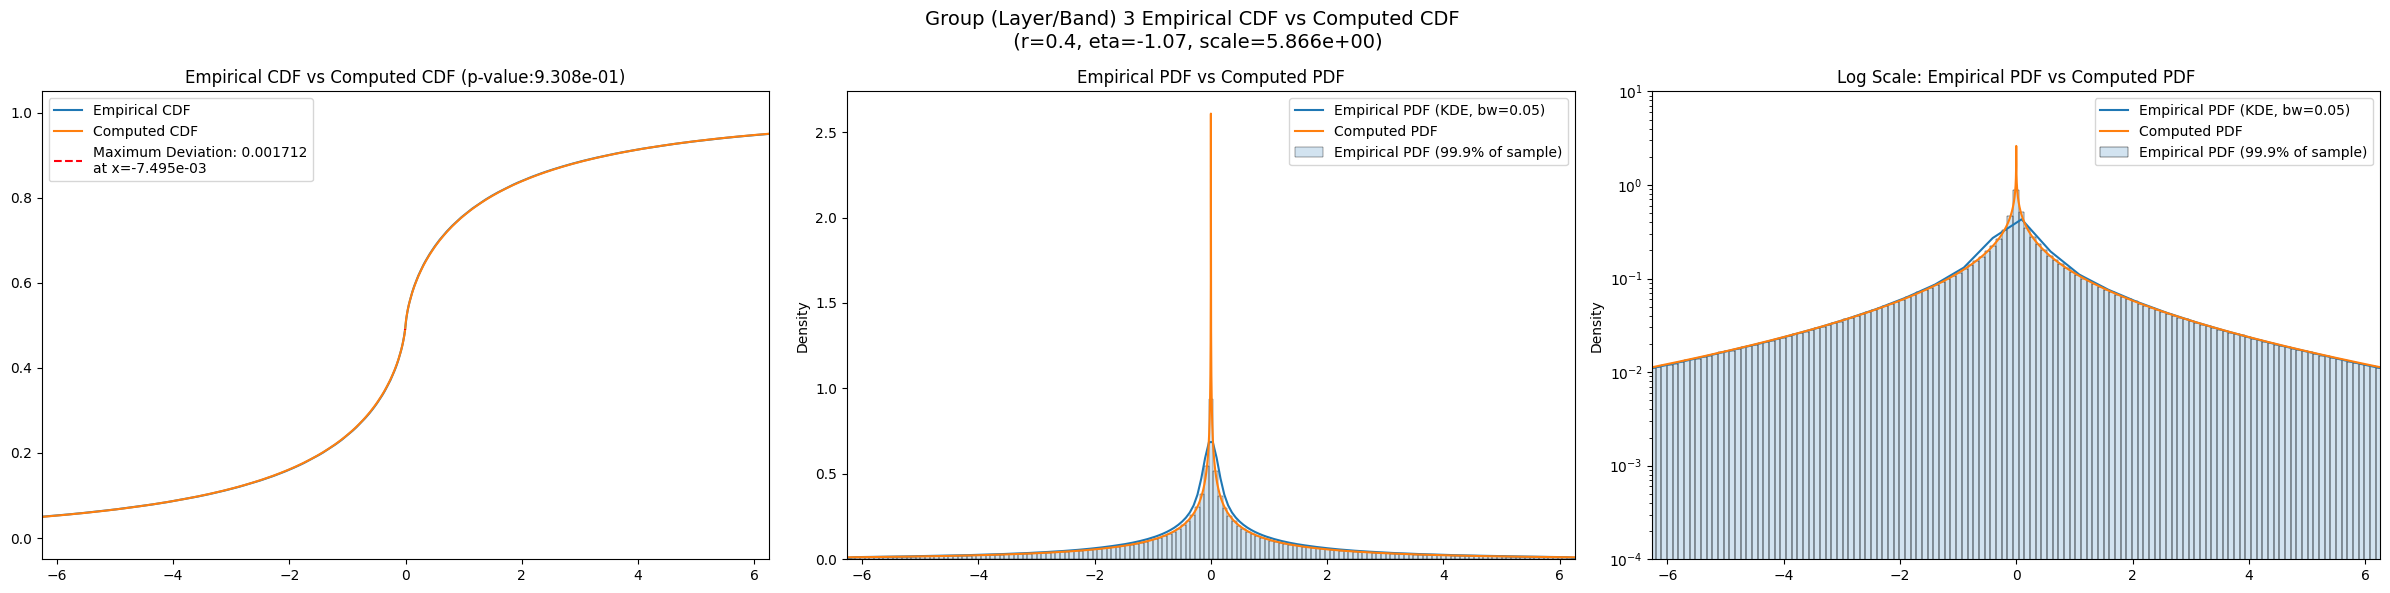

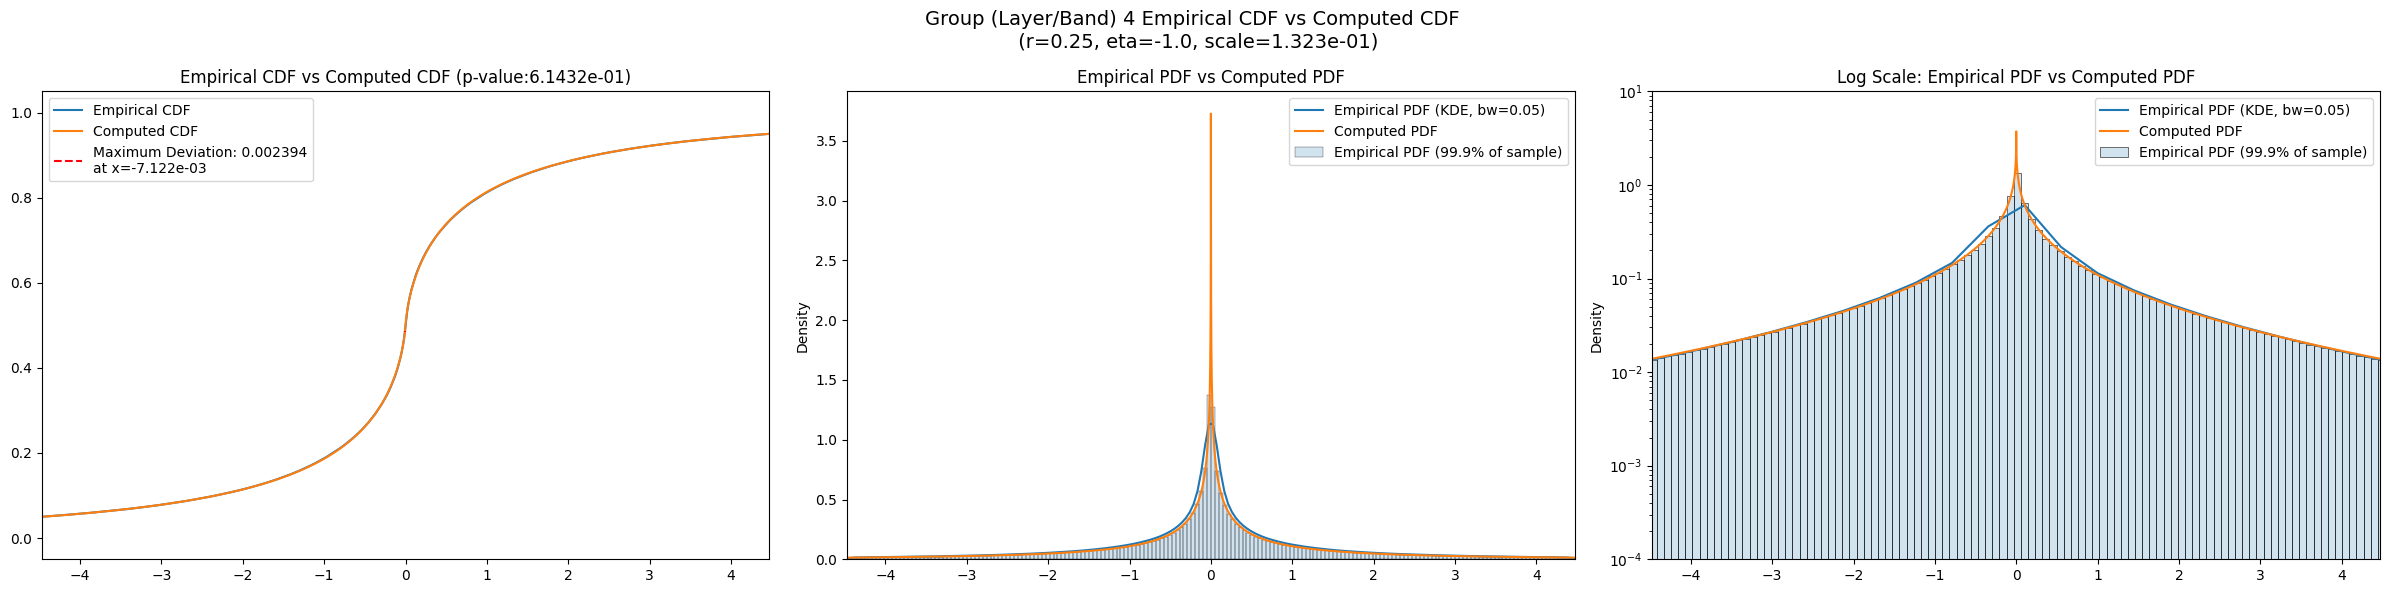

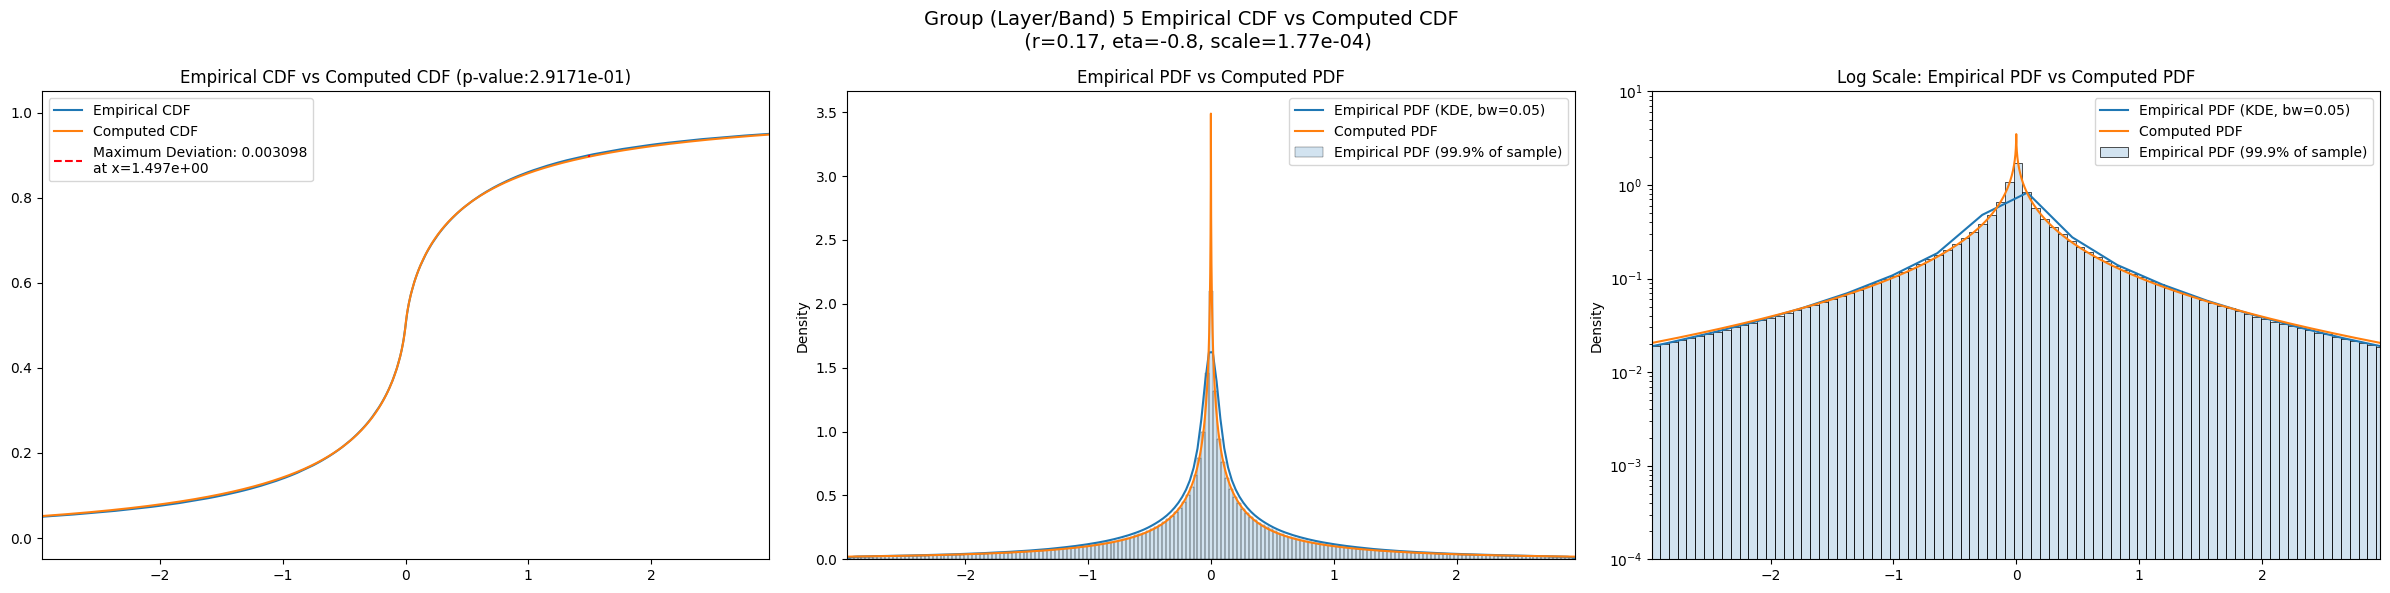

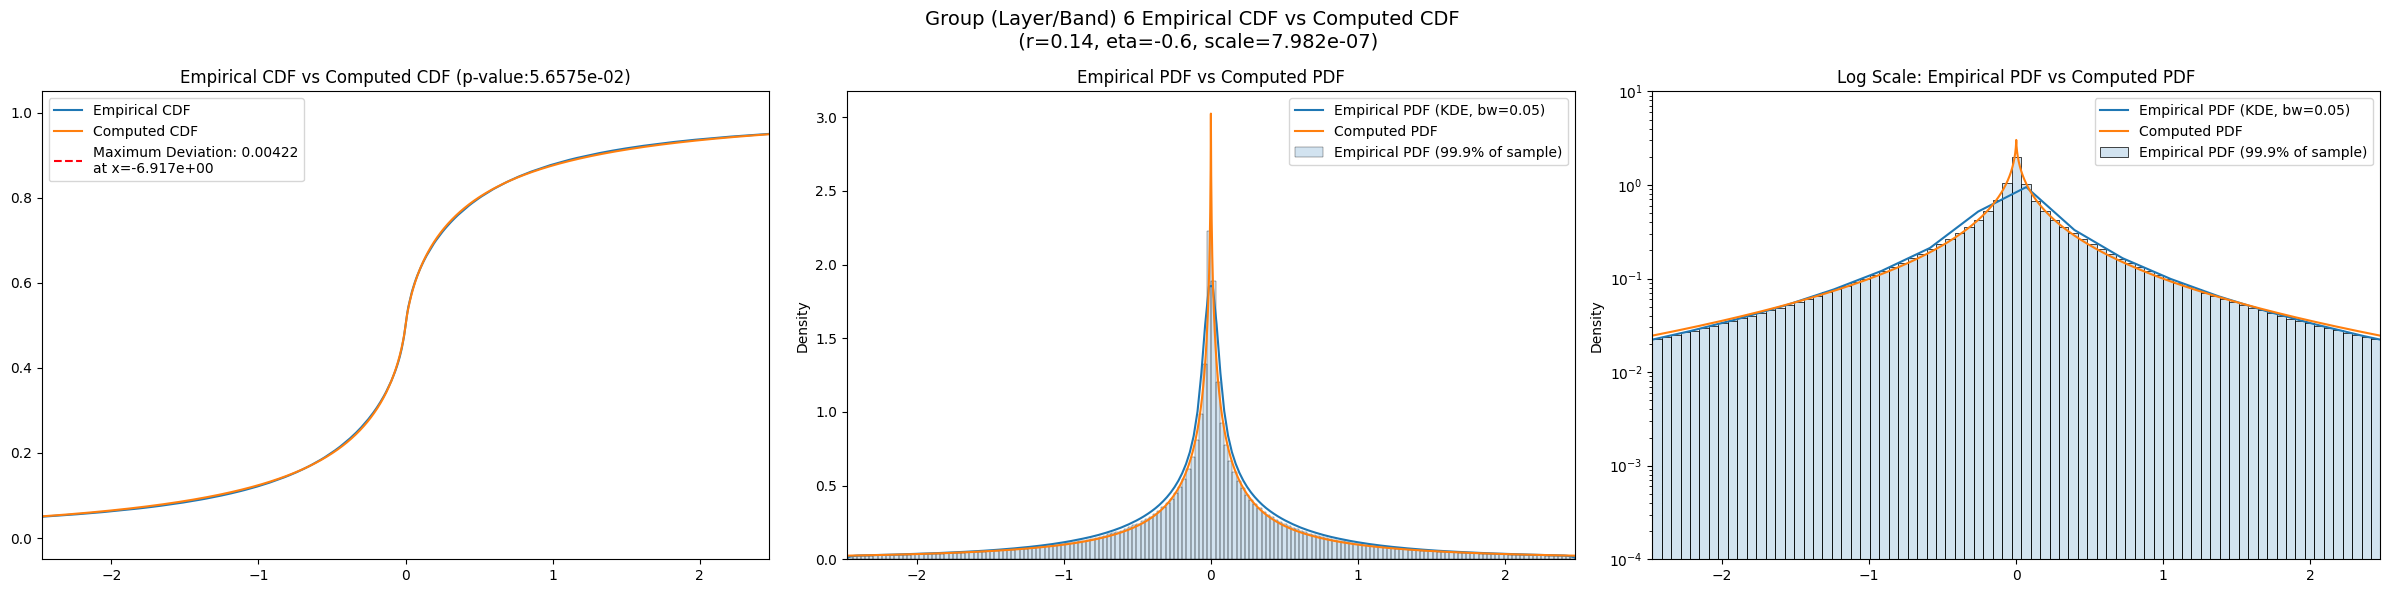

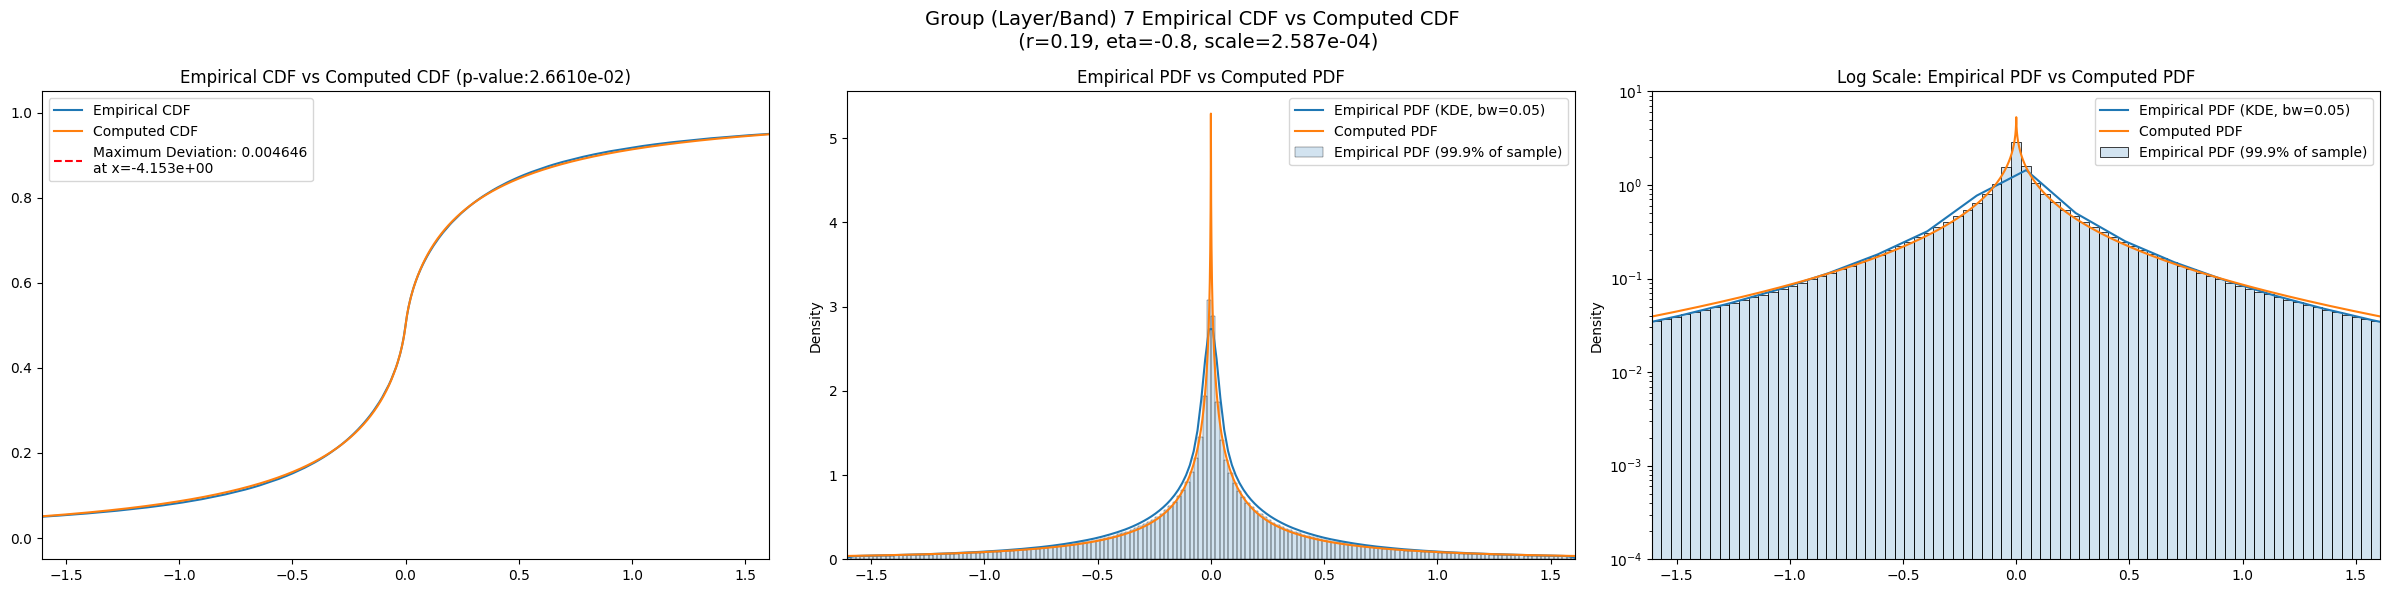

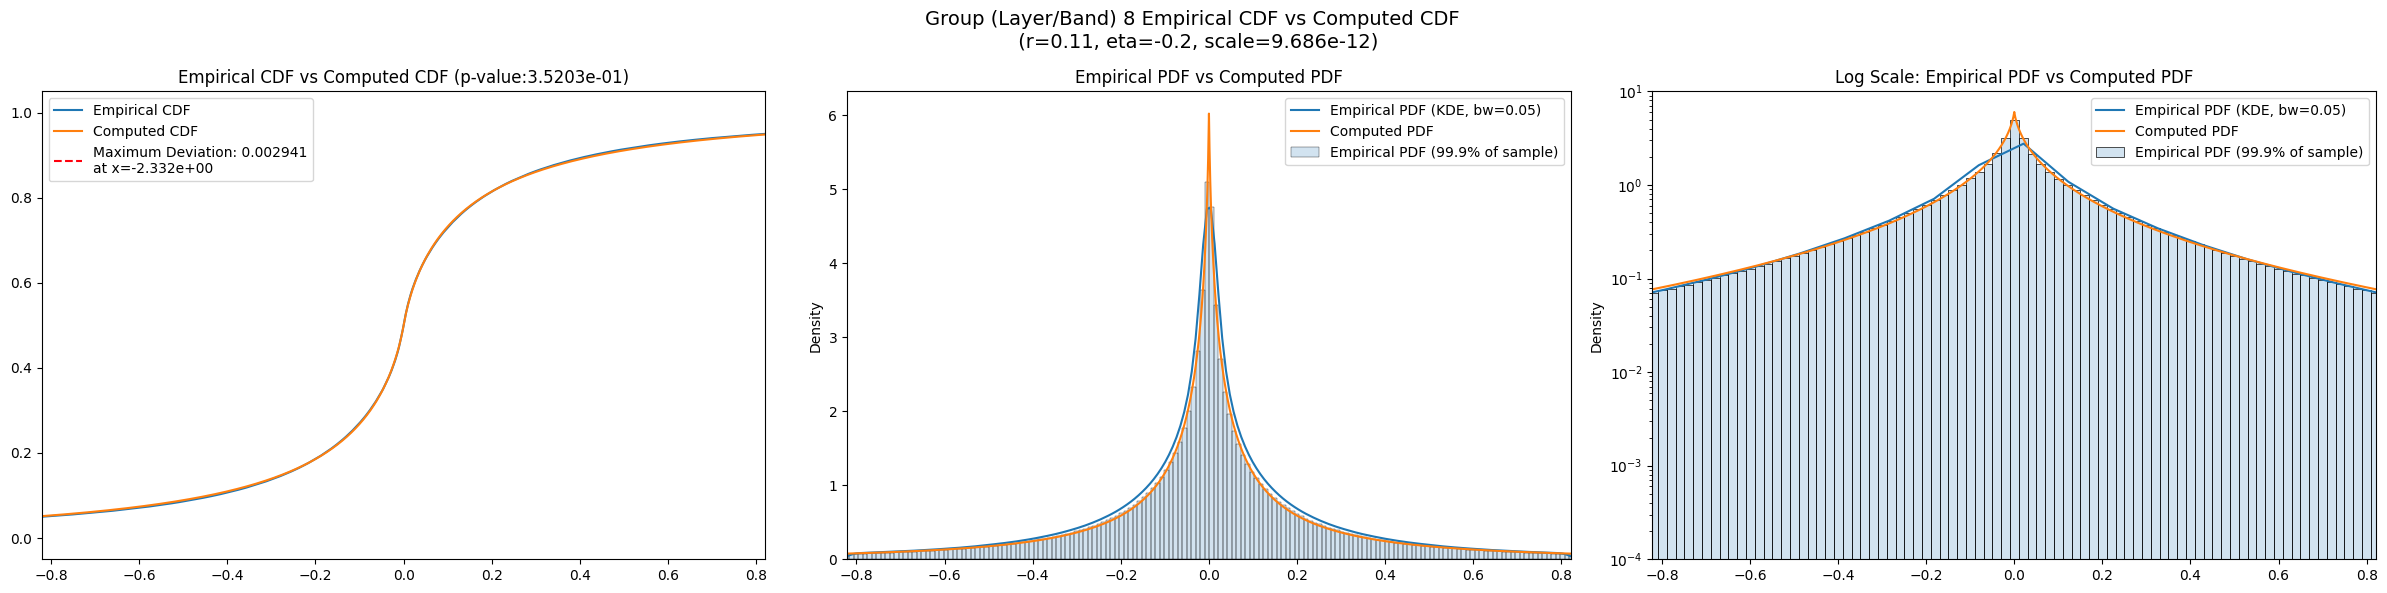

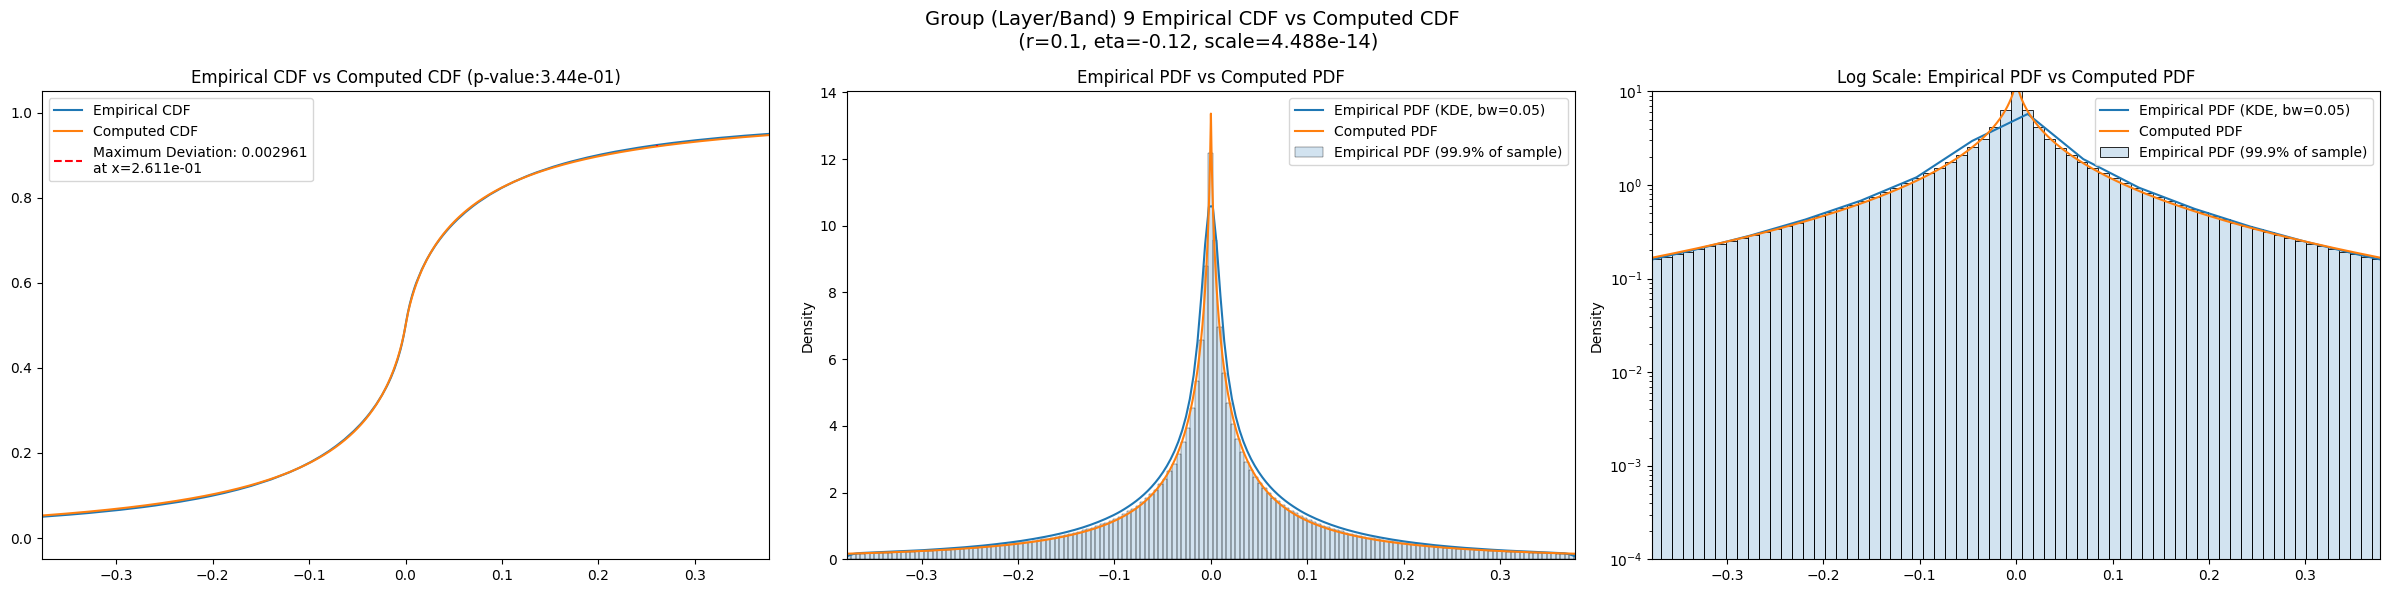

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var  var_lower  var_upper    obs_kurt  kurt_lower  kurt_upper  \
band                                                                        
2     57.350895  47.316536  75.235180    81.11204   20.601892   304.70905   
3     28.362835  23.131216  39.158527   108.53434   22.784437   426.03480   
4     19.804796  15.818209  27.395380   116.36713   31.201988   433.28998   
5     11.807234   9.242341  16.384570   127.57010   39.797090   437.54810   
6      9.799885   7.317126  17.313768   366.21494   40.987793  1174.94620   
7      3.985288   3.034718   5.718637   155.70680   44.850530   512.40840   
8      1.070987   0.702098   2.883485  1710.57890   40.346313  3236.24270   
9      0.259080   0.183806   0.485760   479.14316   54.962437  1437.06140   

      total_samples  kstest_stat_initial  initial_r  initial_eta  ...  \
band                                                              ...   
2          100000.0             0.003890        0.4         -1.0  ...   
3          100000.0             0.002683        0.3         -1.0  ...   
4          100000.0             0.005029        0.2         -0.9  ...   
5          100000.0             0.003490        0.2         -0.9  ...   
6          100000.0             0.006144        0.1         -0.2  ...   
7          100000.0             0.005732        0.2         -0.8  ...   
8          100000.0             0.003049        0.1         -0.1  ...   
9          100000.0             0.004402        0.1         -0.1  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2           2.728160              0.071160                   0.0   
3           1.784870              0.075434                   0.0   
4           1.112840              0.082226                   0.0   
5           0.741412              0.078965                   0.0   
6           0.642440              0.075689                   0.0   
7           0.427314              0.074089                   0.0   
8           0.230722              0.071337                   0.0   
9           0.105521              0.072731                   0.0   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace   param_t  \
band                                                                      
2          2.354730             0.045724        4.044070e-182  1.827700   
3          1.527420             0.050622        3.755780e-223  1.186660   
4          0.953964             0.057860        1.913090e-291  0.733684   
5          0.641006             0.054368        2.378440e-257  0.491074   
6          0.555749             0.051267        7.253850e-229  0.425095   
7          0.370166             0.049554        7.525650e-214  0.283236   
8          0.201053             0.046240        3.072220e-186  0.154459   
9          0.091545             0.047600        2.456770e-197  0.070597   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.046940  6.466580e-192              0.863344  
3          0.052151  8.198110e-237              0.934735  
4          0.058598  6.428590e-299              0.614324  
5          0.054475  2.283610e-258              0.291708  
6          0.051415  3.480730e-230              0.056575  
7          0.049682  5.927270e-215              0.026610  
8          0.046122  2.712810e-185              0.352034  
9          0.047912  6.251260e-200              0.344454  

[8 rows x 30 columns]

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.003890                 0.004293          0.001898   
3                0.002683                 0.004293          0.001698   
4                0.005029                 0.004293          0.002394   
5                0.003490                 0.004293          0.003098   
6                0.006144                 0.004293          0.004220   
7                0.005732                 0.004293          0.004646   
8                0.003049                 0.004293          0.002941   
9                0.004402                 0.004293          0.002960   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.071160             0.045724       0.046940  
3                 0.075434             0.050622       0.052151  
4                 0.082226             0.057860       0.058598  
5                 0.078965             0.054368       0.054475  
6                 0.075689             0.051267       0.051415  
7                 0.074089             0.049554       0.049682  
8                 0.071337             0.046240       0.046122  
9                 0.072731             0.047600       0.047912

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2              47.334736          0.001898    0.36     -1.00  5.659769e+00   
3              22.035343          0.001698    0.40     -1.07  5.866100e+00   
4              15.874792          0.002394    0.25     -1.00  1.322899e-01   
5               9.215591          0.003098    0.17     -0.80  1.769842e-04   
6               6.472932          0.004220    0.14     -0.60  7.981669e-07   
7               2.276741          0.004646    0.19     -0.80  2.587435e-04   
8               0.698575          0.002941    0.11     -0.20  9.686321e-12   
9               0.166658          0.002960    0.10     -0.12  4.487679e-14   

      best_exclude_cutoff  
band                       
2                    50.0  
3                    75.0  
4                    50.0  
5                    50.0  
6                   100.0  
7                   175.0  
8                    50.0  
9                    75.0